In [1]:
# Import libraries
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lars
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")

# Ensure project root is on the path for utils imports
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from utils.metrics import evaluate_model, mape, rmsfe  # noqa: E402

In [2]:
# Load processed data
DATA_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results"
TABLES_DIR = RESULTS_DIR / "tables"
FIGURES_DIR = RESULTS_DIR / "figures"

TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

TARGET_COL = "Core CPI"

train_df = pd.read_csv(DATA_DIR / "train_clean.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv(DATA_DIR / "test_clean.csv", index_col=0, parse_dates=True)

X_train = train_df.drop(columns=[TARGET_COL])
y_train = train_df[TARGET_COL]
X_test = test_df.drop(columns=[TARGET_COL])
y_test = test_df[TARGET_COL]

print(f"Số mẫu huấn luyện: {len(train_df):,} | Số đặc trưng: {X_train.shape[1]}")
print(f"Số mẫu kiểm tra: {len(test_df):,}")

Số mẫu huấn luyện: 112 | Số đặc trưng: 189
Số mẫu kiểm tra: 28


In [3]:
# LARS model
lars_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", Lars())
    ]
)

param_grid = {
    "model__n_nonzero_coefs": [5, 10, 15, 20, 30],
    "model__eps": [1e-6, 1e-5, 1e-4]
}

tscv = TimeSeriesSplit(n_splits=5)

lars_grid = GridSearchCV(
    estimator=lars_pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

lars_grid.fit(X_train, y_train)
best_model = lars_grid.best_estimator_

print("Tham số tốt nhất:", lars_grid.best_params_)
print(f"RMSFE tốt nhất (CV): {-lars_grid.best_score_:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Tham số tốt nhất: {'model__eps': 1e-06, 'model__n_nonzero_coefs': 10}
RMSFE tốt nhất (CV): 0.0927



LARS - Train Performance:
  RMSFE: 0.0310
  MAPE:  12.93%

LARS - Test Performance:
  RMSFE: 0.1144
  MAPE:  16.09%


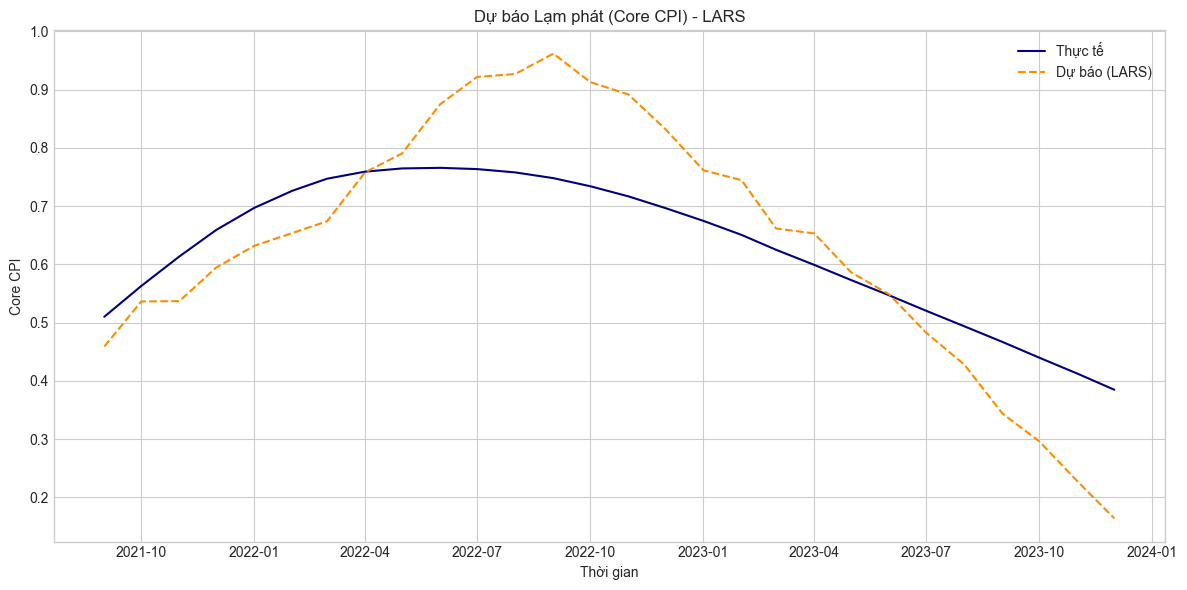

Đã lưu biểu đồ tại D:\IS403.Q11\inflation-forecasting\results\figures\lars_forecast.png


In [4]:
# Evaluation
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_metrics = evaluate_model(y_train, y_train_pred, model_name="LARS - Train")
test_metrics = evaluate_model(y_test, y_test_pred, model_name="LARS - Test")

metrics_df = pd.DataFrame([
    {"Split": "Train", "RMSFE": train_metrics["RMSFE"], "MAPE": train_metrics["MAPE"]},
    {"Split": "Test", "RMSFE": test_metrics["RMSFE"], "MAPE": test_metrics["MAPE"]},
])

metrics_df

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Thực tế", color="navy")
plt.plot(y_test.index, y_test_pred, label="Dự báo (LARS)", color="darkorange", linestyle="--")
plt.title("Dự báo Lạm phát (Core CPI) - LARS")
plt.xlabel("Thời gian")
plt.ylabel("Core CPI")
plt.legend()
plt.tight_layout()

forecast_fig_path = FIGURES_DIR / "lars_forecast.png"
plt.savefig(forecast_fig_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Đã lưu biểu đồ tại {forecast_fig_path}")

In [5]:
# Save results
predictions_df = pd.DataFrame(
    {
        "Actual": y_test,
        "Predicted_LARS": y_test_pred
    },
    index=y_test.index
)

pred_path = TABLES_DIR / "lars_predictions.csv"
metrics_path = TABLES_DIR / "lars_metrics.csv"

predictions_df.to_csv(pred_path)
metrics_df.to_csv(metrics_path, index=False)

best_params_path = TABLES_DIR / "lars_best_params.txt"
with open(best_params_path, "w", encoding="utf-8") as f:
    f.write(str(lars_grid.best_params_))

print(f"Đã lưu dự báo tại {pred_path}")
print(f"Đã lưu chỉ số đánh giá tại {metrics_path}")
print(f"Đã lưu tham số tốt nhất tại {best_params_path}")

Đã lưu dự báo tại D:\IS403.Q11\inflation-forecasting\results\tables\lars_predictions.csv
Đã lưu chỉ số đánh giá tại D:\IS403.Q11\inflation-forecasting\results\tables\lars_metrics.csv
Đã lưu tham số tốt nhất tại D:\IS403.Q11\inflation-forecasting\results\tables\lars_best_params.txt
